**Sudeshna Bora**

**AAND Numerical Assignment 04**

In [1]:
#import library
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import math

**1**

In [2]:
h1_data = sio.loadmat("c1p8.mat")
spikes = h1_data['rho'].flatten()
stimulus = h1_data['stim'].flatten()
spikes.shape

(600000,)

Given,

500 spikes in 1000 ms. 

Hence, 1 spike per ms . 

$\Delta t = 2$ 

Now,

20 minutes or 1200 seconds is the total duration. Additonally with 2ms resolution. So total length will be 

$\frac{20*60*1000}{2} = 600000$

We can also visualise it as 1 index represents a time of 2 ms.

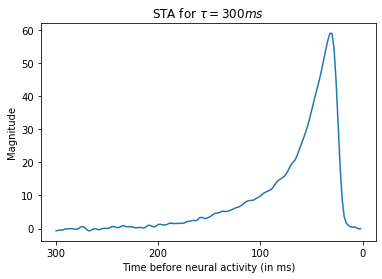

In [3]:
tau = 300
num_timesteps = int(tau/2)  # adjusting resolution
C = np.zeros(num_timesteps)
dt = 2
n = spikes.sum()

for i in range(len(C)):
    C[i] = np.trapz(spikes * np.roll(stimulus, i), dx=dt) / n
C = C[::-1]

fig, ax1 = plt.subplots(1)
plt.plot(C)
ax1.set_xticks([0, 50, 100, 150])
ax1.set_xticklabels(['300', '200', '100', '0'])
ax1.set_xlabel('Time before neural activity (in ms)')
ax1.set_title(r'STA for $\tau = 300 ms$')
ax1.set_ylabel('Magnitude')
plt.show()

**2**

We will use $\frac{spikeCount}{Trial length}$ for mean firing rate

In [4]:
T = 20*60*1000
dt = 2
mean_firing_rate = spikes.sum() / T
stimulus_variance = stimulus.var() * dt
D = mean_firing_rate * C / stimulus_variance
print(mean_firing_rate)

0.0446675


**3**

In [5]:
r_est = np.convolve(D, stimulus, mode='same')
r_est -= r_est.mean()
r_est += mean_firing_rate
print(np.mean(r_est))

0.04466749999999999


In [6]:
def sliding_window_function(tau, delta): return 1 / \
    delta if tau >= -delta/2 and tau < delta/2 else 0

In [7]:
t = np.zeros(1000)
spike_slice = spikes[5000:6000]
spike_index = spike_slice.nonzero()

response = np.zeros(1000)
for t in range(len(response)):
    for spike_time in spike_index[0]:
        response[t] += sliding_window_function(t - spike_time, 20)
        

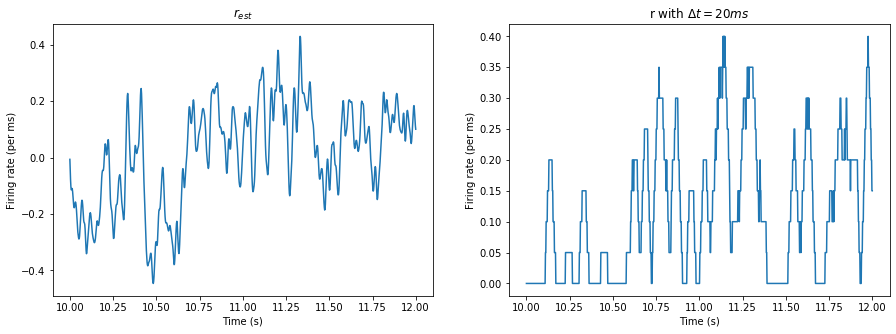

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

plt.sca(ax1)
plt.plot(np.linspace(10, 12, 1000), r_est[5000:6000])
plt.xlabel('Time (s)')
plt.ylabel('Firing rate (per ms)')
plt.title('$r_{est}$')

plt.sca(ax2)
plt.plot(np.linspace(10, 12, 1000), response)
plt.xlabel('Time (s)')
plt.ylabel('Firing rate (per ms)')
plt.title('r with $\\Delta t = 20 ms$')
plt.show()